# Flight delay prediction
## 2. Models



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("flight_model_var.csv", header = 0, index_col= 0)

C:\Users\ben\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2.1 splitting data train/test set

In [3]:
# Splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split

y = df.loc[:,"ARR_DELAY"]
X = df.drop("ARR_DELAY", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [4]:
X_train.head()

,HOURS,AA,AS,B6,DL,EV,F9,HA,NK,OO,...,Summer,Winter,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Big_Airport
2028236,14.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2728262,9.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4828419,12.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4662754,18.0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3217764,11.0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


## 2.2 Simple linear regresion

In [5]:
# import model
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score

We will build 3 linear models with different set of features:  
1. model "hsd" with temporal features: hours, seasons and days of the week
2. model "ca" with with informative features: carrier and airport 
3. model "all" with with all features  
Note that we can remove some dummy features: season and one day of the week since the information is indirectly already present in the rest (for example if spring, summer and Autumn = 0 then by deduction it means winter = 1).
We reduce the number of features by removing "Winter" and "Monday", "AA". This mean that the coefficient of the linear model will be relatif to the "reference" case: "AA", "Winter", "Monday".
we will then assess the model performances by using the Root mean square error (RMSE). To asssess the out of sample RMSE, we will use Kfold validation. We use 5 folds rather than 10 just for computing time reduction.

In [6]:
# Temporal features (_hsd)
X_hsd_train = X_train.loc[:,('HOURS', 'Spring', 'Summer', 'Autumn','Tuesday', 
                             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')]
X_hsd_test = X_test.loc[:,('HOURS','Spring', 'Summer', 'Autumn','Tuesday', 
                           'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')]
linreg_hsd = LinearRegression()
scores_hsd = cross_val_score(linreg_hsd, X_hsd_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [7]:
# informative features (_ca)
X_ca_train = X_train.loc[:,('AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', 'OO', 'UA', 'VX', 'WN','Big_Airport')]   ## Winter not here it will be the reference
X_ca_test = X_test.loc[:,('AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', 'OO', 'UA', 'VX', 'WN','Big_Airport')]
linreg_ca = LinearRegression()
scores_ca = cross_val_score(linreg_ca, X_ca_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [8]:
# All features (_all)
X_all_train = X_train.loc[:,"HOURS":"Big_Airport"]   ## Winter not here it will be the reference
X_all_test = X_test.loc[:,"HOURS":"Big_Airport"]
X_all_train = X_all_train.drop(["Winter", "Monday","AA"], axis = 1)
X_all_test = X_all_test.drop(["Winter", "Monday","AA"], axis = 1)
linreg_all = LinearRegression()
scores_all = cross_val_score(linreg_all, X_all_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [9]:
print("Input features:\t\t\t hsd \t ca \t all")
print("Root Mean Squared Error (RMSE):\t",round(((-scores_hsd)**0.5).mean(),2),"\t",
                                          round(((-scores_ca)**0.5).mean(),2),"\t",
                                          round(((-scores_all)**0.5).mean(),2))

Input features:			 hsd 	 ca 	 all
Root Mean Squared Error (RMSE):	 18.44 	 18.6 	 18.38


Lowest RMSE for using all features. However the differences are quite small. 

In [10]:
del X_ca_train, X_hsd_test, X_hsd_train, X_ca_test

In [11]:
linreg_all.fit(X_all_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
# coef interpretations
feature_names = X_all_train.columns.values
f = list(zip(feature_names, linreg_all.coef_))
feat_df = pd.DataFrame(f,columns= ("features","relative_delay"))
feat_df.sort_values(by = "relative_delay", ascending= False)

,features,relative_delay
7,NK,2.118732
2,B6,1.864575
14,Summer,1.835227
10,VX,1.545854
5,F9,0.931156
18,Thursday,0.851128
15,Friday,0.842028
21,Big_Airport,0.837158
0,HOURS,0.502790
4,EV,-0.314812


From our model, it seems features with bigest weight on delay are "summer" and  "NK, B6, VX" companies. On the other hand, "HA", "DL", "AS" and "Saturday" are the ones that minimize the delay.
since Hours can have values from 5 to 23 (others features are just 0 or 1), the variation can actually go from 0 to 18*0.427 ~ 7.5. So hours have also a big influence.

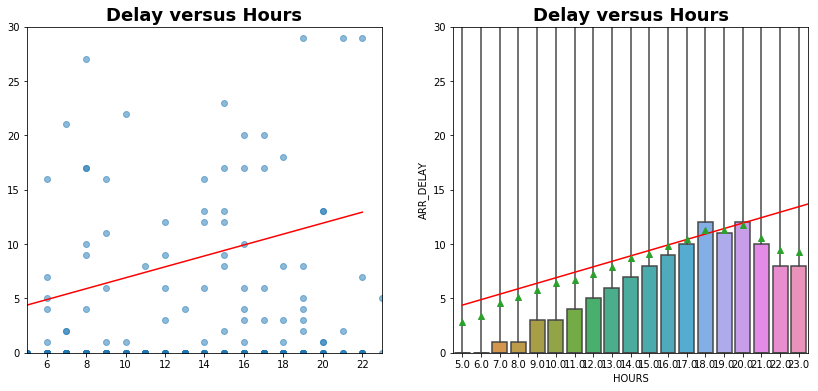

In [14]:
# vizualise the regression line on "HOURS"
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
samp = df.sample(300)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
plt.scatter(x="HOURS", y="ARR_DELAY", data=samp, alpha = 0.5)   #, order = top2bot)
u = np.linspace(0,22,5)
plt.plot(u,u*linreg_all.coef_[0]+linreg_all.intercept_, c="red", label="linear fit")
plt.ylim(0,30)
plt.xlim(5,23)


plt.subplot(1,2,2)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
sns.boxplot(x="HOURS", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)
plt.plot(u,(u+5)*linreg_all.coef_[0]+linreg_all.intercept_, c="red", label="linear fit")

plt.show()

In the followinf section we will integrate a polynomial feature (second order) on "HOURS" to see if we can improve the model.

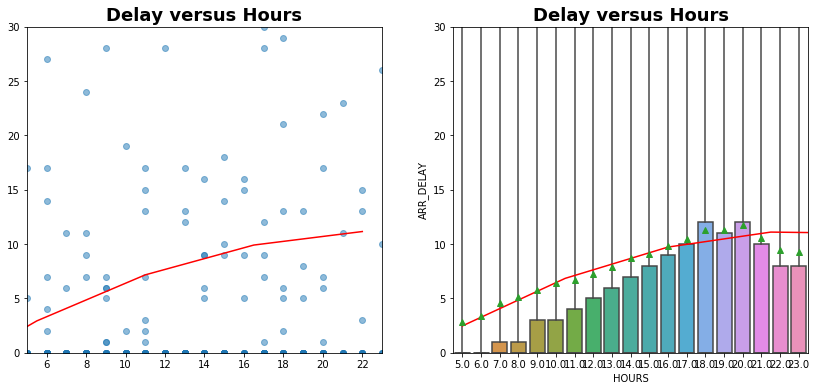

In [15]:
# polynomial features for hours

# inputs
x = X_train.loc[:,["HOURS"]]
x["HOURS2"] = x["HOURS"]**2

# model 
linreg_h2 = LinearRegression()
linreg_h2.fit(x, y_train)
scores_h2 = cross_val_score(linreg_h2, x, y_train, cv=5, scoring='neg_mean_squared_error')

# plot
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
samp = df.sample(300)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
plt.scatter(x="HOURS", y="ARR_DELAY", data=samp, alpha = 0.5)   #, order = top2bot
u = np.linspace(0,22,5)
plt.plot(u,(u**2)*linreg_h2.coef_[1]+u*linreg_h2.coef_[0]+linreg_h2.intercept_, c="red", label="linear fit")
plt.ylim(0,30)
plt.xlim(5,23)

plt.subplot(1,2,2)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
sns.boxplot(x="HOURS", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)
plt.plot(u,((u+5)**2)*linreg_h2.coef_[1]+(u+5)*linreg_h2.coef_[0]+linreg_h2.intercept_, c="red", label="linear fit")

plt.show()

In [16]:
# RMSE with Kflod on hours and poly(hours)

# hours
X_h_train = X_train.loc[:,["HOURS"]]   ## Winter not here it will be the reference
X_h_test = X_test.loc[:,["HOURS"]]
linreg_h = LinearRegression()
scores_h = cross_val_score(linreg_h, X_h_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("Input features:\t\t\t h \t h2")
print("Root Mean Squared Error (RMSE):\t",round(((-scores_h)**0.5).mean(),2),"\t",
                                          round(((-scores_h2)**0.5).mean(),2),"\t")

Input features:			 h 	 h2
Root Mean Squared Error (RMSE):	 18.5 	 18.5 	


It seems that even if the fit seems slightly better on the average, there is no reduction of the RMSE. We will continue with all features (without polynomial feature).

## 2.3 Ridge regression

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV 

ridgreg = Ridge()
param_grid = {"alpha": np.logspace(-5, 8, 16)}  # different alpha we want to test
grid = GridSearchCV(ridgreg, param_grid, cv=5, scoring= "neg_mean_squared_error")
grid.fit(X_all_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-05, 7.35642e-05, 5.41170e-04, 3.98107e-03, 2.92864e-02,
       2.15443e-01, 1.58489e+00, 1.16591e+01, 8.57696e+01, 6.30957e+02,
       4.64159e+03, 3.41455e+04, 2.51189e+05, 1.84785e+06, 1.35936e+07,
       1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

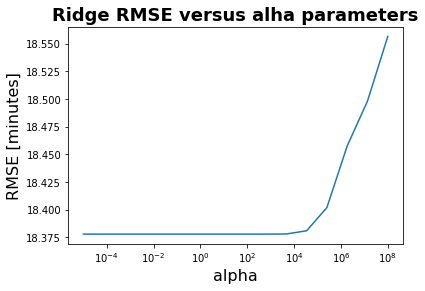

In [18]:
# results Ridge: alpha values versus RMSE

# inputs
alpha = grid.cv_results_['param_alpha'].data
RMSE = (-grid.cv_results_['mean_test_score'])**0.5

# plot
ax = plt.gca()
plt.title("Ridge RMSE versus alha parameters", fontweight="bold", size = 18)
ax.plot(alpha, RMSE)
ax.set_xscale('log')
plt.xlabel('alpha', size = 16)
plt.ylabel('RMSE [minutes]', size = 16)
plt.axis('tight')
plt.show()

Since there is no RMSE below RMSE(alpha=0), Ridge regression does not improve (reduce the error) compared to the first standard linear model (alpha = 0).

## 2.4 Lasso regression
Let's have the same approch with Lasso regression.

In [19]:
from sklearn.linear_model import Lasso

lasso = Lasso()
param_grid = {"alpha": np.logspace(-5, 8, 16)}  # different alpha we want to test
grid = GridSearchCV(lasso, param_grid, cv=5, scoring= "neg_mean_squared_error")
grid.fit(X_all_train, y_train)
alpha = grid.cv_results_['param_alpha'].data
RMSE = (-grid.cv_results_['mean_test_score'])**0.5

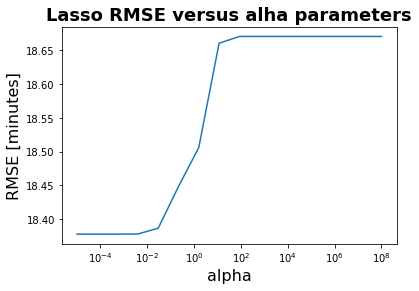

In [20]:
# results Lasso: alpha values versus RMSE

# plot
ax = plt.gca()
plt.title("Lasso RMSE versus alha parameters", fontweight="bold", size = 18)
ax.plot(alpha, RMSE)
ax.set_xscale('log')
plt.xlabel('alpha', size = 16)
plt.ylabel('RMSE [minutes]', size = 16)
plt.axis('tight')
plt.show()

As the ridge regression, the Lasso regression does not reduce the Errorc compare to the standard model.

## 2.5 model export
Neither Ridge or Lasso show improvement. We choose to save the "simple" linear model with all features.

In [22]:
# RMSE with the test set
from sklearn.metrics import mean_squared_error
y_pred = linreg_all.predict(X_all_test)
score =  mean_squared_error(y_test, y_pred)
print("RMSE of the linear model with all feature on the test set is {} minutes".format(round((score**0.5),1)))

RMSE of the linear model with all feature on the test set is 18.3 minutes


In [19]:
import joblib as job    # lib to import/export python objects
job.dump(linreg_all, "linearM_airline_delay.gz")

['linearM_airline_delay.gz']